In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
current_pwd = os.getcwd()

possible_paths = [
    '/home/export/soheuny/SRFinder/soheun/notebooks', 
    '/home/soheuny/HH4bsim/soheun/notebooks'
]
    
assert os.getcwd() in possible_paths, f"Did you change the path? It should be one of {possible_paths}"
os.chdir("..")

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import torch

from plots import hist_events_by_labels
from events_data import EventsData
from fvt_classifier import FvTClassifier
from tst_info import TSTInfo
# import LogNorm
from matplotlib.colors import LogNorm


features = [
    "sym_Jet0_pt", "sym_Jet1_pt", "sym_Jet2_pt", "sym_Jet3_pt",
    "sym_Jet0_eta", "sym_Jet1_eta", "sym_Jet2_eta", "sym_Jet3_eta",
    "sym_Jet0_phi", "sym_Jet1_phi", "sym_Jet2_phi", "sym_Jet3_phi",  
    "sym_Jet0_m", "sym_Jet1_m", "sym_Jet2_m", "sym_Jet3_m",
]

In [7]:
from itertools import product
from training_info import TrainingInfo
from plots import calibration_plot, plot_rewighted_samples_by_model
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from ancillary_features import get_m4j
from pl_callbacks import CalibrationPlotCallback, ReweightedPlotCallback

# use tex
# plt.rcParams["text.usetex"] = True
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["text.usetex"] = False

plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.titlesize"] = 20
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["figure.labelsize"] = 20
plt.rcParams["lines.markersize"] = 3

## Architecture: Deeper ResNet

100%|██████████| 22/22 [00:00<00:00, 24.04it/s]


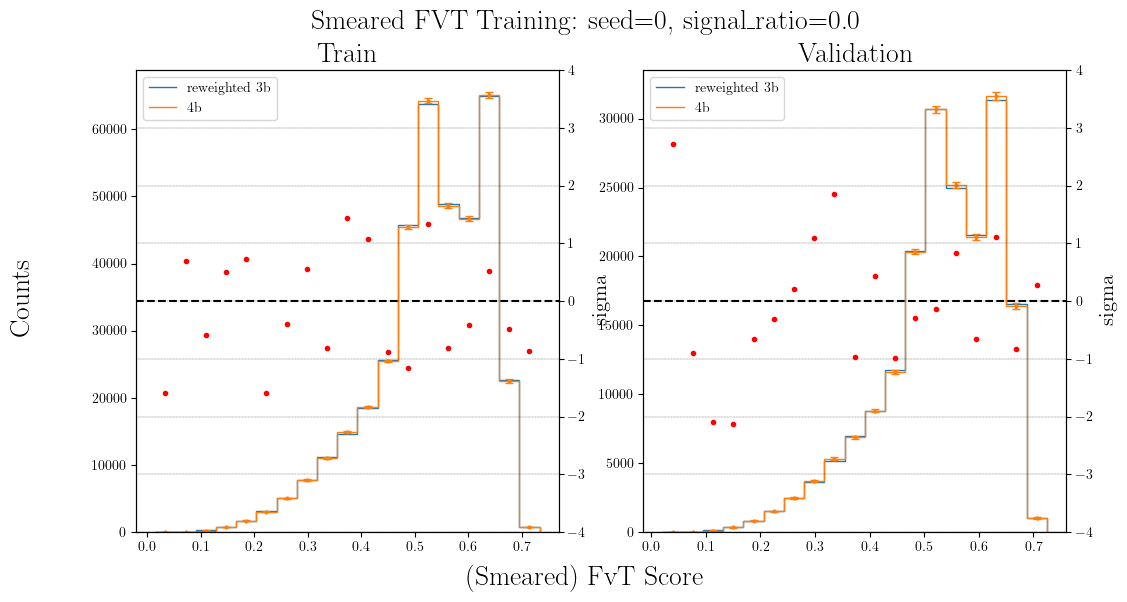

100%|██████████| 22/22 [00:00<00:00, 23.49it/s]


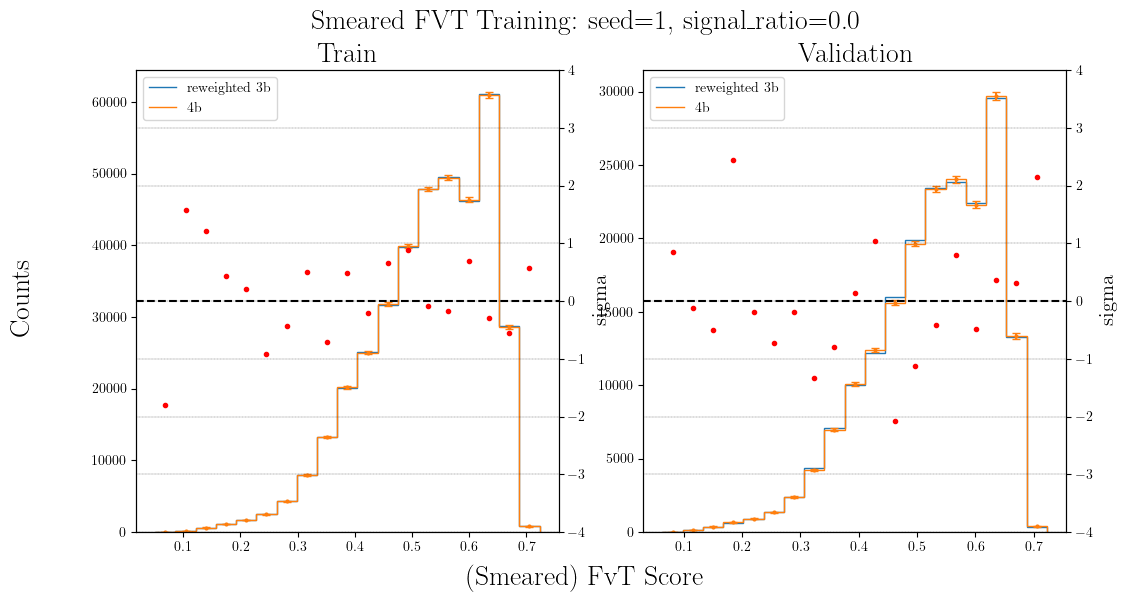

100%|██████████| 22/22 [00:00<00:00, 27.17it/s]


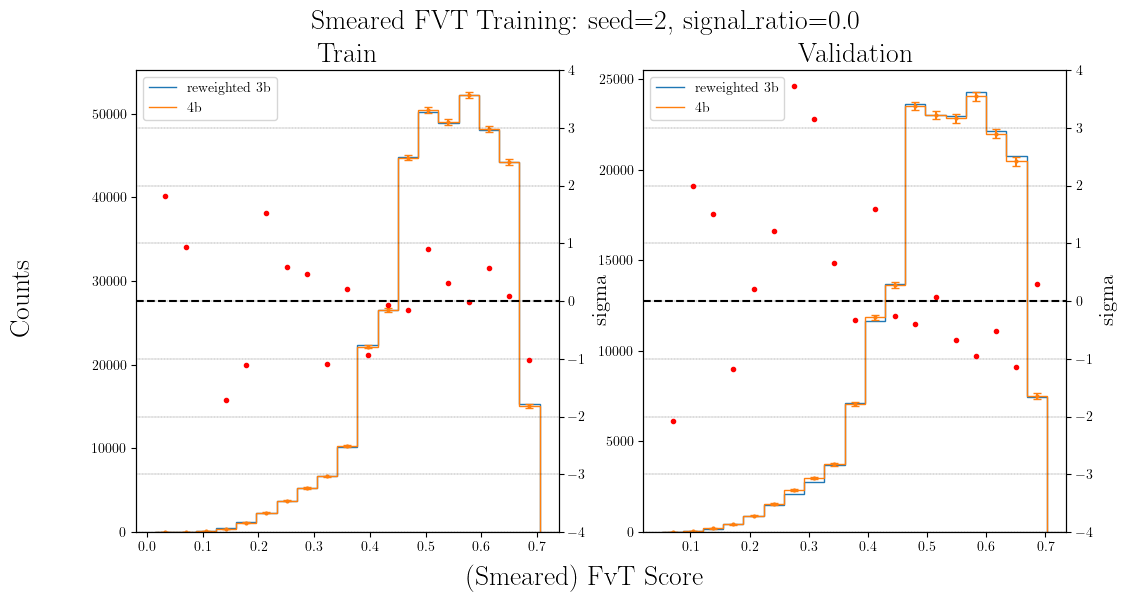

100%|██████████| 22/22 [00:00<00:00, 26.88it/s]


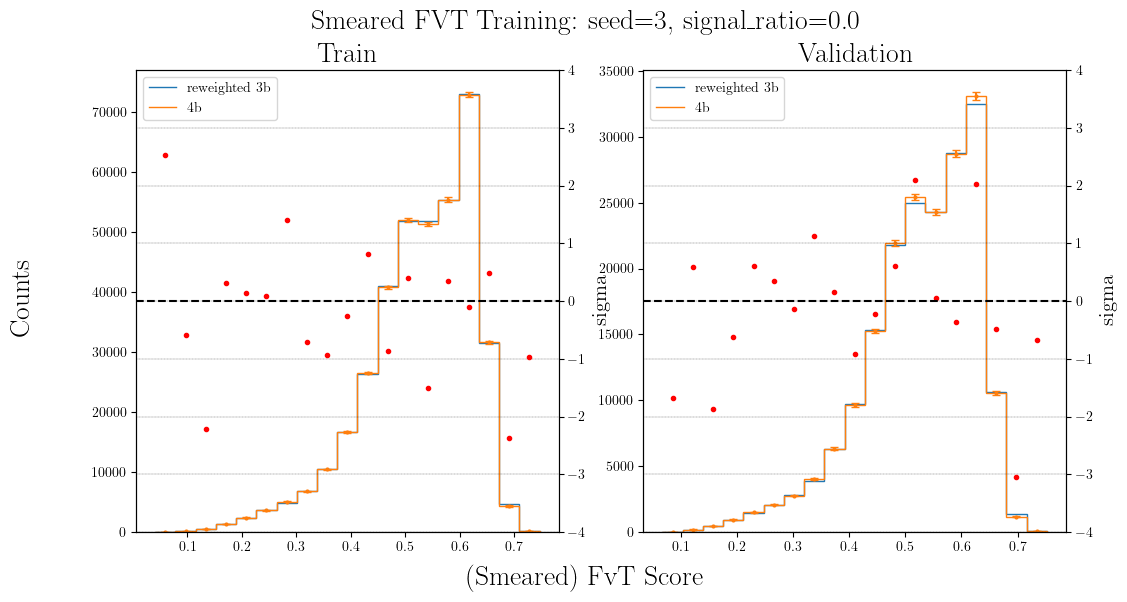

100%|██████████| 22/22 [00:00<00:00, 24.12it/s]


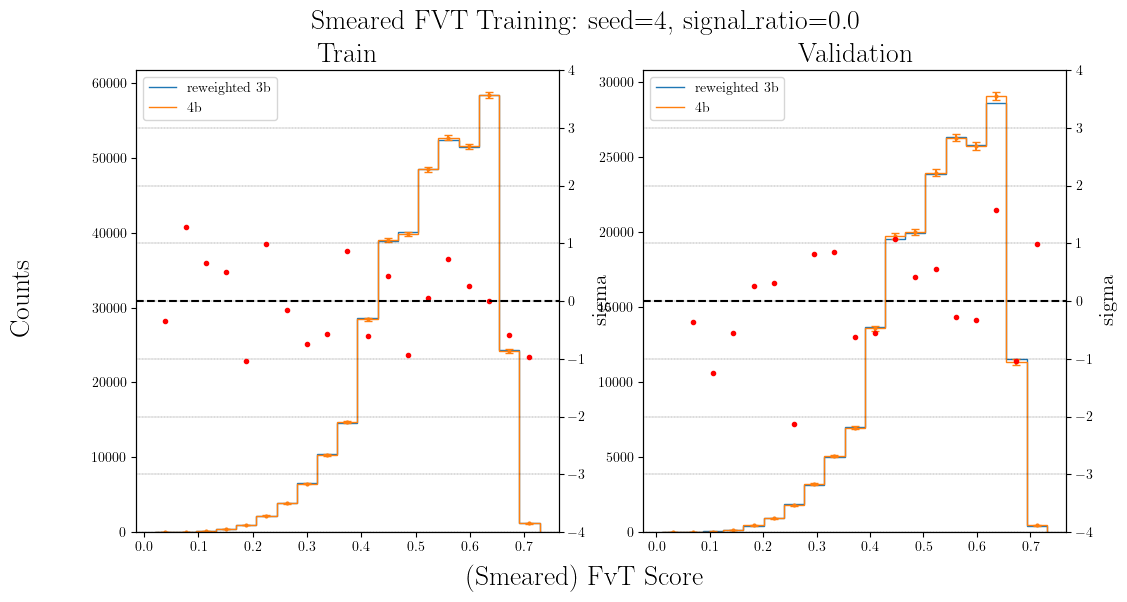

In [24]:
import time
import pytorch_lightning as pl
from events_data import events_from_scdinfo
from training_info import TrainingInfo

n_3b = 100_0000
device = torch.device("cuda")
experiment_name = "smeared_fvt_training"
signal_filename = "HH4b_picoAOD.h5"
ratio_4b = 0.5

seeds = [0, 1, 2, 3, 4]
hparam_filter = {
    "experiment_name": lambda x: x in [experiment_name],
    "dataset": lambda x: all([x["seed"] in seeds, 
                              x["n_3b"] == n_3b, 
                              x["signal_ratio"] == 0.0]),
}
hashes = TrainingInfo.find(hparam_filter)

for hash_ in hashes:
    smeared_fvt_tinfo = TrainingInfo.load(hash_)

    smeared_fvt_train_dset, smeared_fvt_val_dset = (
        smeared_fvt_tinfo.fetch_train_val_smeared_features(
            features,
            label="fourTag",
            weight="weight",
            label_dtype=torch.long,
        )
    )

    smeared_fvt_model = smeared_fvt_tinfo.load_trained_model("best")
    device = torch.device("cuda")
    smeared_fvt_model.to(device)
    smeared_fvt_model.eval()

    from plots import plot_reweighted_samples_raw

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f"Smeared FvT Training: seed={smeared_fvt_tinfo.hparams['dataset']['seed']}, signal_ratio={smeared_fvt_tinfo.hparams['dataset']['signal_ratio']}")
    fig.supxlabel("(Smeared) FvT Score")
    fig.supylabel("Counts")

    for ax_cnt, dset in enumerate([smeared_fvt_train_dset, smeared_fvt_val_dset]):
        fvt_score = smeared_fvt_model.predict(dset.tensors[0], do_tqdm=True)[:, 1].to("cpu").numpy()
        is_4b = dset.tensors[1].to("cpu").numpy()
        weights = dset.tensors[2].to("cpu").numpy()
        reweights = np.where(is_4b, 1, fvt_score / (1 - fvt_score))
        
        ax[ax_cnt].set_title("Train" if ax_cnt == 0 else "Validation")

        plot_reweighted_samples_raw(
            is_4b, weights, fvt_score, reweights, ax[ax_cnt]
        )
    plt.show()
    plt.close("all")

In [10]:
hashes = TrainingInfo.find({"model": "AttentionClassifier"})

encoder_hashes = [TrainingInfo.load(hash).hparams["encoder_hash"] for hash in hashes]
np.unique(encoder_hashes, return_counts=True)

(array(['241013_212934_867665_L8To7G', '241013_212948_027352_a1nlRH',
        '241013_212951_200086_dRpcKA', '241013_225522_378366_4UGotD',
        '241013_225523_078756_Bs4V78', '241013_225530_730422_0kXBDQ',
        '241013_232236_089597_kbi1xO', '241013_232241_883851_J0yorb',
        '241013_232321_248267_PzmNpb', '241013_234934_858755_6EaRm5',
        '241013_234937_894047_JIHovE', '241013_235034_470891_bqoLet',
        '241014_001354_280897_EPMo7p', '241014_001407_647692_7bLkoK',
        '241014_001535_766776_NK4cXh', '241014_003820_833364_hRBMD8',
        '241014_003901_065679_HkHF3O', '241014_004043_677585_bE5sgF',
        '241014_010505_060440_YQ54ce', '241014_010558_139922_wE8DfQ',
        '241014_010757_433910_nagMap', '241014_013029_169243_14wmJ2',
        '241014_013214_578767_unTlp5', '241014_013513_201606_ShNRLo',
        '241014_015717_611508_B6SdHP', '241014_015918_112032_dGB1RV',
        '241014_020222_435651_LPedO1', '241014_022339_250428_usIlmC',
        '241014_0226

In [3]:
def smear_features(X: np.ndarray, noise_scale: float, seed: int, hard_cutoff: bool = False, scale_mode: str = "std"):
    if scale_mode == "std":
        base_scale = np.std(X, axis=0)
    elif scale_mode == "range":
        features_min = np.min(X, axis=0)
        features_max = np.max(X, axis=0)
        base_scale = features_max - features_min
    else:
        raise ValueError(f"Invalid scale_mode: {scale_mode}")
    
    accept_mask = np.zeros_like(X, dtype=bool)
    X_smeared = np.zeros_like(X)
    
    np.random.seed(seed)
    if hard_cutoff:
        while True:
            X_smeared[~accept_mask] = (X + noise_scale * base_scale * np.random.randn(*X.shape))[~accept_mask]
            accept_mask = (X_smeared >= features_min) & (X_smeared <= features_max)
            if np.all(accept_mask):
                break
    else:
        X_smeared = X + noise_scale * base_scale * np.random.randn(*X.shape)
        
    return X_smeared

seed=0, n_3b=1000000, signal_ratio=0.02


100%|██████████| 64/64 [00:04<00:00, 15.71it/s]
[rank: 0] Seed set to 0
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
[n02:3478784] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.n02.3393/jf.0/211156992/shared_mem_cuda_pool.n02 could be created.
[n02:3478784] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is

Epoch 10:   0%|          | 0/43 [00:00<?, ?it/s, v_num=3, val_loss=0.657, val_sigma_sq=1.970, train_loss=0.658]        

/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 15:   0%|          | 0/22 [00:00<?, ?it/s, v_num=3, val_loss=0.657, val_sigma_sq=1.350, train_loss=0.658]         

/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 29: 100%|██████████| 22/22 [00:14<00:00,  1.48it/s, v_num=3, val_loss=0.657, val_sigma_sq=1.160, train_loss=0.658]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 22/22 [00:15<00:00,  1.46it/s, v_num=3, val_loss=0.657, val_sigma_sq=1.160, train_loss=0.658]


100%|██████████| 64/64 [00:02<00:00, 23.52it/s]


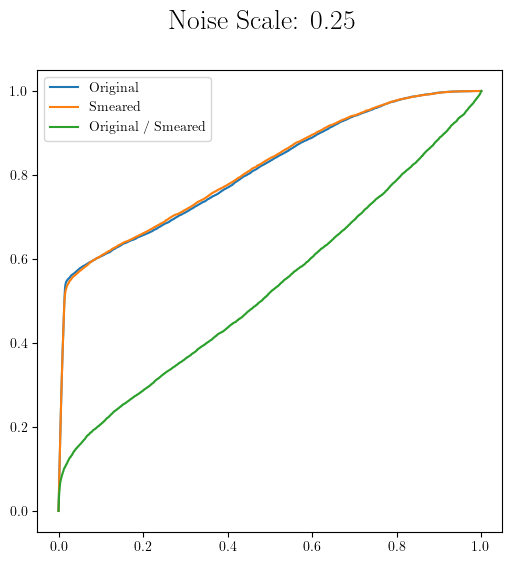

[rank: 0] Seed set to 0
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type        | Params
-----------------------------------------
0 | select_q | ResNetBlock | 344   
1 | out      | ResNetBlock | 352   
-----------------------------------------
696       Trainable params
0         Non-trainable params
696       Total params
0.003     Total estimated model params size (MB)


Epoch 10:   0%|          | 0/43 [00:00<?, ?it/s, v_num=1, val_loss=0.659, val_sigma_sq=23.70, train_loss=0.659]        

/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 15:   0%|          | 0/22 [00:00<?, ?it/s, v_num=1, val_loss=0.659, val_sigma_sq=22.30, train_loss=0.659]         

/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 29: 100%|██████████| 22/22 [00:14<00:00,  1.47it/s, v_num=1, val_loss=0.658, val_sigma_sq=1.610, train_loss=0.659]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 22/22 [00:15<00:00,  1.44it/s, v_num=1, val_loss=0.658, val_sigma_sq=1.610, train_loss=0.659]


100%|██████████| 64/64 [00:02<00:00, 24.43it/s]


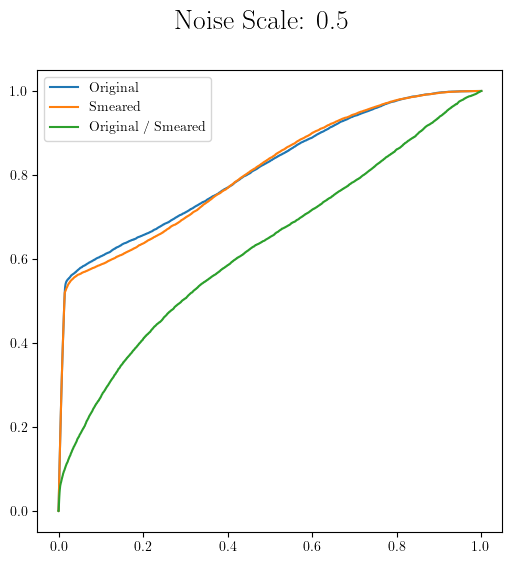

[rank: 0] Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type        | Params
-----------------------------------------
0 | select_q | ResNetBlock | 344   
1 | out      | ResNetBlock | 352   
-----------------------------------------
696       Trainable params
0         Non-trainable params
696       Total params
0.003     Total estimated model params size (MB)


Epoch 29: 100%|██████████| 22/22 [00:14<00:00,  1.50it/s, v_num=1, val_loss=0.662, val_sigma_sq=2.820, train_loss=0.663]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 22/22 [00:15<00:00,  1.44it/s, v_num=1, val_loss=0.662, val_sigma_sq=2.820, train_loss=0.663]


100%|██████████| 64/64 [00:02<00:00, 24.95it/s]


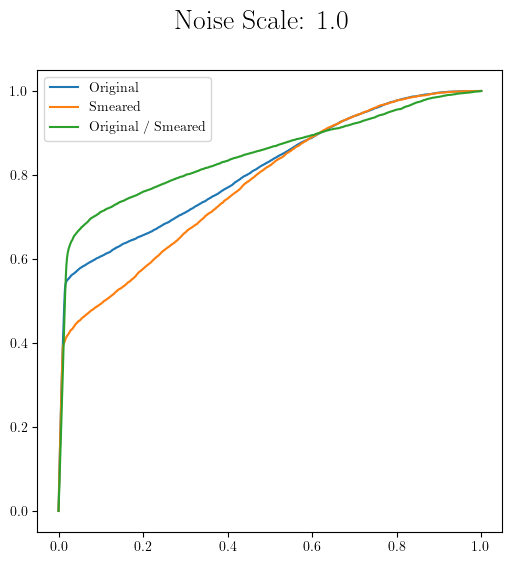

[rank: 0] Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type        | Params
-----------------------------------------
0 | select_q | ResNetBlock | 344   
1 | out      | ResNetBlock | 352   
-----------------------------------------
696       Trainable params
0         Non-trainable params
696       Total params
0.003     Total estimated model params size (MB)


Epoch 29: 100%|██████████| 22/22 [00:17<00:00,  1.23it/s, v_num=1, val_loss=0.667, val_sigma_sq=2.440, train_loss=0.668]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 22/22 [00:18<00:00,  1.16it/s, v_num=1, val_loss=0.667, val_sigma_sq=2.440, train_loss=0.668]


100%|██████████| 64/64 [00:02<00:00, 25.41it/s]


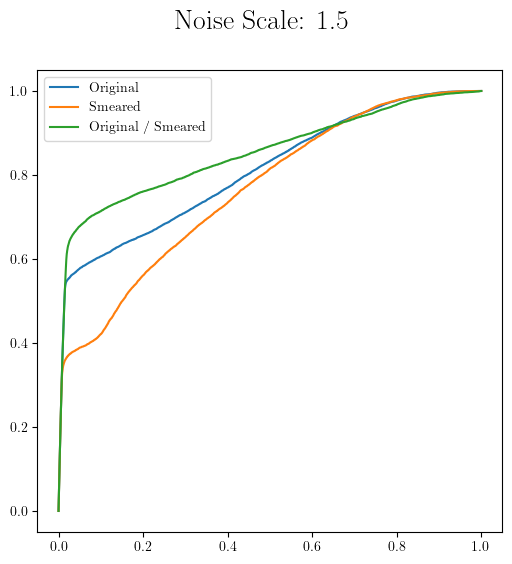

[rank: 0] Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs/smeared_fvt_training_tmp/smeared_fvt_training_tmp_depth=8_seed=0_lrs=True_bsch=True_noise_scale=2.0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type        | Params
-----------------------------------------
0 | select_q | ResNetBlock | 344   
1 | out      | ResNetBlock | 352   
-----------------------------------------
696       Trainable params
0         Non-trainable params
696       Total params
0.003     Total estimated model params size (MB)


Epoch 29: 100%|██████████| 22/22 [00:16<00:00,  1.35it/s, v_num=0, val_loss=0.672, val_sigma_sq=2.640, train_loss=0.673]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 22/22 [00:17<00:00,  1.24it/s, v_num=0, val_loss=0.672, val_sigma_sq=2.640, train_loss=0.673]


100%|██████████| 64/64 [00:02<00:00, 24.55it/s]


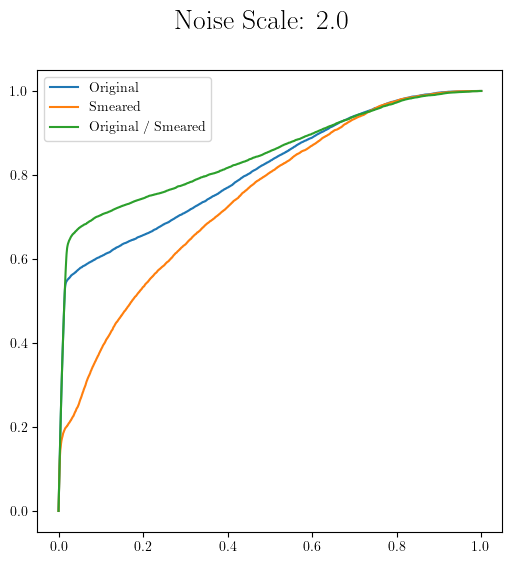

[rank: 0] Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs/smeared_fvt_training_tmp/smeared_fvt_training_tmp_depth=8_seed=0_lrs=True_bsch=True_noise_scale=3.0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type        | Params
-----------------------------------------
0 | select_q | ResNetBlock | 344   
1 | out      | ResNetBlock | 352   
-----------------------------------------
696       Trainable params
0         Non-trainable params
696       Total params
0.003     Total estimated model params size (MB)


Epoch 29: 100%|██████████| 22/22 [00:26<00:00,  0.83it/s, v_num=0, val_loss=0.680, val_sigma_sq=2.290, train_loss=0.680]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 22/22 [00:28<00:00,  0.78it/s, v_num=0, val_loss=0.680, val_sigma_sq=2.290, train_loss=0.680]


100%|██████████| 64/64 [00:02<00:00, 24.99it/s]


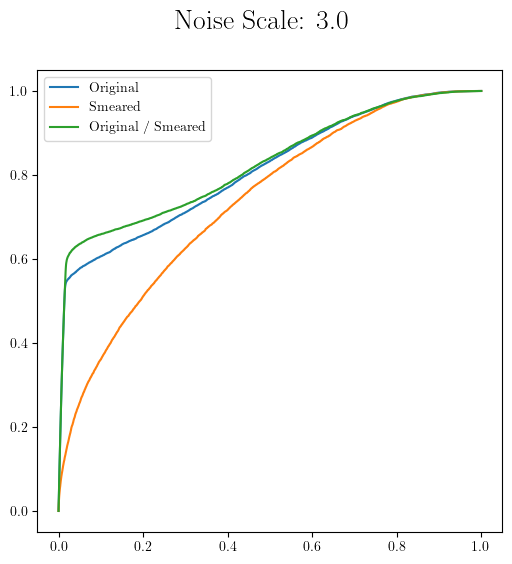

[rank: 0] Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_logs/smeared_fvt_training_tmp/smeared_fvt_training_tmp_depth=8_seed=0_lrs=True_bsch=True_noise_scale=4.0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type        | Params
-----------------------------------------
0 | select_q | ResNetBlock | 344   
1 | out      | ResNetBlock | 352   
-----------------------------------------
696       Trainable params
0         Non-trainable params
696       Total params
0.003     Total estimated model params size (MB)


Epoch 29: 100%|██████████| 22/22 [00:18<00:00,  1.19it/s, v_num=0, val_loss=0.685, val_sigma_sq=2.090, train_loss=0.685]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 22/22 [00:20<00:00,  1.08it/s, v_num=0, val_loss=0.685, val_sigma_sq=2.090, train_loss=0.685]


100%|██████████| 64/64 [00:02<00:00, 25.56it/s]


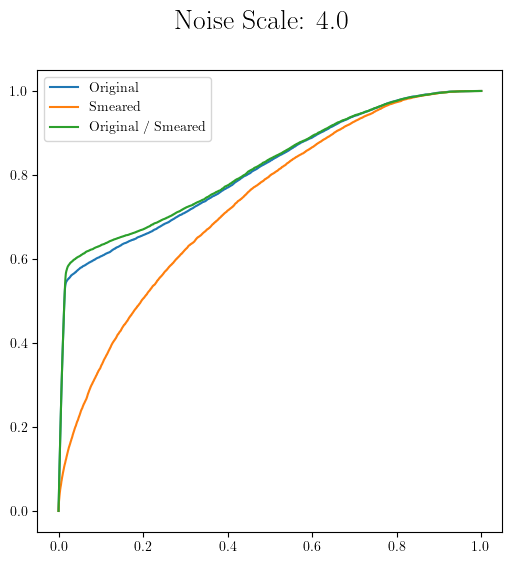

Error in callback <bound method AutoreloadMagics.post_execute_hook of <IPython.extensions.autoreload.AutoreloadMagics object at 0x7efdf407f990>> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [4]:
import time
import pytorch_lightning as pl
from events_data import events_from_scdinfo
from training_info import TrainingInfo

n_3b = 100_0000
device = torch.device("cuda")
experiment_name = "better_base_fvt_training"
signal_filename = "HH4b_picoAOD.h5"
ratio_4b = 0.5

seeds = [0]
hparam_filter = {
    "experiment_name": lambda x: x in [experiment_name],
    "dataset": lambda x: all([x["seed"] in seeds, 
                              x["n_3b"] == n_3b, 
                              x["signal_ratio"] == 0.02]),
}
hashes = TrainingInfo.find(hparam_filter)

noise_scale = 0.5
depth = 8
batch_size = 1024
max_epochs = 30

gamma_dict = {}

for tinfo_hash in hashes:
    tinfo = TrainingInfo.load(tinfo_hash)
    model = tinfo.load_trained_model("best")
    seed = tinfo.hparams["dataset"]["seed"]
    n_3b = tinfo.hparams["dataset"]["n_3b"]
    signal_ratio = tinfo.hparams["dataset"]["signal_ratio"]
    print(
        f"seed={seed}, n_3b={n_3b}, signal_ratio={signal_ratio}"
    )
    
    model.eval()
    model.to(device)
    events_train = events_from_scdinfo(tinfo.scdinfo, features, signal_filename)
    events_train.shuffle(seed=seed)
    q_repr, view_scores = model.representations(events_train.X_torch)
    
    
    from attention_classifier import AttentionClassifier
    from sklearn.model_selection import train_test_split
    from torch.utils.data import TensorDataset

    
    tb_log_dir = "smeared_fvt_training_tmp"
    optimizer_config = {
        "type": "Adam",
        "lr": 1e-2,
    }
    lr_scheduler_config = {
        "type": "ReduceLROnPlateau",
        "factor": 0.25,
        "patience": 3,
        "min_lr": 2e-4,
        "cooldown": 1,
        "threshold": 1e-4,
    }
    early_stop_patience = None
    dataloader_config = {
        "batch_size": batch_size,
        "batch_size_milestones": [1, 3, 6, 10, 15],
        "batch_size_multiplier": 2,
    }
    
    from dataset import MotherSamples
    ms_scdinfo = MotherSamples.load(tinfo._ms_hash).scdinfo
    events_tst = events_from_scdinfo(ms_scdinfo[~tinfo._ms_idx], features, signal_filename)
    events_tst.shuffle(seed=seed)
    probs_4b_tst = model.predict(events_tst.X_torch, do_tqdm=True)[:, 1].to("cpu").numpy()
    q_repr_tst, _ = model.representations(events_tst.X_torch)
    gamma_tst = probs_4b_tst / (1 - probs_4b_tst)
    gamma_dict[0.0] = gamma_tst

    
    for noise_scale in [0.25, 0.5, 1.0, 1.5, 2.0, 3.0, 4.0]:
        q_repr_smear = smear_features(q_repr.numpy(), noise_scale, seed, hard_cutoff=False, scale_mode="std")
        q_sm_train, q_sm_val, is_4b_train, is_4b_val, weights_train, weights_val = train_test_split(
        q_repr_smear, events_train.is_4b, events_train.weights, test_size=0.33, random_state=seed
        )
        q_sm_train = torch.tensor(q_sm_train, dtype=torch.float32)
        q_sm_val = torch.tensor(q_sm_val, dtype=torch.float32)
        is_4b_train = torch.tensor(is_4b_train, dtype=torch.long)
        is_4b_val = torch.tensor(is_4b_val, dtype=torch.long)
        weights_train = torch.tensor(weights_train, dtype=torch.float32)
        weights_val = torch.tensor(weights_val, dtype=torch.float32)


        q_sm_train = q_sm_train[:batch_size * (len(q_sm_train) // batch_size)]
        is_4b_train = is_4b_train[:batch_size * (len(is_4b_train) // batch_size)]
        weights_train = weights_train[:batch_size * (len(weights_train) // batch_size)]

        q_sm_val = q_sm_val[:batch_size * (len(q_sm_val) // batch_size)]
        is_4b_val = is_4b_val[:batch_size * (len(is_4b_val) // batch_size)]
        weights_val = weights_val[:batch_size * (len(weights_val) // batch_size)]

        train_dataset = TensorDataset(q_sm_train, is_4b_train, weights_train)
        val_dataset = TensorDataset(q_sm_val, is_4b_val, weights_val)
        
        pl.seed_everything(seed)
        att_classifier = AttentionClassifier(
            dim_q=q_repr.shape[1],
            num_classes=2,
            depth=depth,
            run_name=f"smeared_fvt_training_tmp_depth={depth}_seed={seed}_lrs=True_bsch=True_noise_scale={noise_scale}",
        )

        att_classifier.to(device)
        att_classifier.fit(
            train_dataset, val_dataset,
            max_epochs=max_epochs,
            optimizer_config=optimizer_config,
            lr_scheduler_config=lr_scheduler_config,
            early_stop_patience=early_stop_patience,
            dataloader_config=dataloader_config,
            tb_log_dir=tb_log_dir,
        )
        
        att_classifier.eval()
        att_classifier.to(device)
        probs_4b_smeared_tst = att_classifier.predict(q_repr_tst, do_tqdm=True)[:, 1].to("cpu").numpy()

        gamma_tilde_tst = probs_4b_smeared_tst / (1 - probs_4b_smeared_tst)

        from plots import plot_sr_stats

        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        fig.suptitle(f"Noise Scale: {noise_scale}")
        plot_sr_stats(events_tst, gamma_tst, ax, label="Original")
        plot_sr_stats(events_tst, gamma_tilde_tst, ax, label="Smeared")
        plot_sr_stats(events_tst, gamma_tst / gamma_tilde_tst, ax, label="Original / Smeared")
        plt.legend()
        plt.show()
        
        gamma_dict[noise_scale] = gamma_tilde_tst

In [ ]:
gamma_dict

In [3]:
def get_SR_CR_cut(SR_stats: np.ndarray, events_tst: EventsData, SRCR_hparams: dict):
    assert len(SR_stats) == len(events_tst)
    assert "4b_in_SR" in SRCR_hparams and "4b_in_CR" in SRCR_hparams
    
    W_4B_CUT_MIN = 0.001
    W_4B_CUT_MAX = 0.999
    
    
    SR_stats_argsort = np.argsort(SR_stats)[::-1]
    SR_stats_sorted = SR_stats[SR_stats_argsort]
    weights = events_tst.weights[SR_stats_argsort]
    is_4b = events_tst.is_4b[SR_stats_argsort]
    cumul_4b_ratio = np.cumsum(weights * is_4b) / np.sum(weights * is_4b)

    w_4b_SR_ratio = np.clip(SRCR_hparams["4b_in_SR"], W_4B_CUT_MIN, W_4B_CUT_MAX)
    w_4b_CR_ratio = np.clip(
        SRCR_hparams["4b_in_CR"] + SRCR_hparams["4b_in_SR"], W_4B_CUT_MIN, W_4B_CUT_MAX
    )

    SR_cut, CR_cut = None, None
    for i in range(1, len(cumul_4b_ratio)):
        if cumul_4b_ratio[i] > w_4b_SR_ratio and SR_cut is None:
            SR_cut = SR_stats_sorted[i - 1]
        if cumul_4b_ratio[i] > w_4b_CR_ratio and CR_cut is None:
            CR_cut = SR_stats_sorted[i - 1]
        if SR_cut is not None and CR_cut is not None:
            break

    # If the cut is not found, set the cut to the minimum value
    # Both SR and CR cuts should be different
    if SR_cut is None:
        SR_cut = SR_stats_sorted[-1]
    if CR_cut is None:
        CR_cut = SR_stats_sorted[-1]
    if SR_cut == CR_cut:
        raise ValueError("SR and CR cuts are the same")

    return SR_cut, CR_cut

  0%|          | 0/1 [00:00<?, ?it/s]

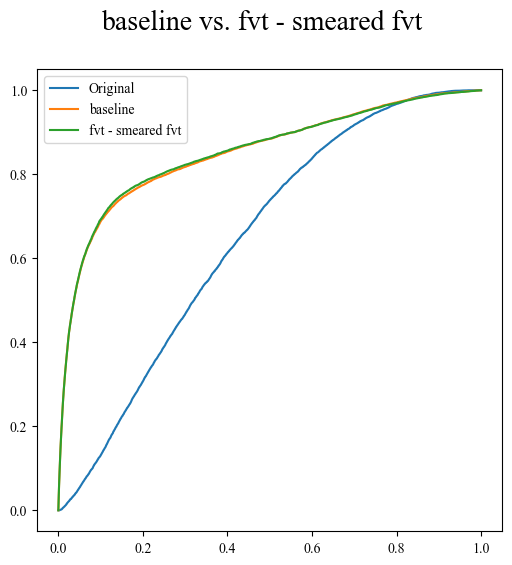

100%|██████████| 1/1 [00:07<00:00,  7.60s/it]


In [23]:
import tqdm
from dataset import MotherSamples
from events_data import events_from_scdinfo
from plots import plot_sr_stats

n_3b = 100_0000
device = torch.device("cuda")
experiment_name = "smeared_fvt_training"
signal_filename = "HH4b_picoAOD.h5"
ratio_4b = 0.5
seeds = [1]
signal_ratio = 0.02

hparam_filter = {
    "experiment_name": lambda x: x in [experiment_name],
    "dataset": lambda x: all([x["seed"] in seeds, 
                            x["n_3b"] == n_3b, 
                            x["signal_ratio"] == signal_ratio]),
    "model": "AttentionClassifier",
    "aux_info_step": 2
}
hashes = TrainingInfo.find(hparam_filter)

SRCR_hparams = {
    "4b_in_SR": 0.05,
    "4b_in_CR": 0.45
}
cal_bins = np.linspace(0, 1, 4)
quantiles = np.linspace(0, 1, 4)

for tinfo_hash in tqdm.tqdm(hashes):
    smeared_tinfo = TrainingInfo.load(tinfo_hash)
    seed = smeared_tinfo.hparams["dataset"]["seed"]
    smeared_fvt = smeared_tinfo.load_trained_model("best")
    smeared_fvt.eval()
    smeared_fvt.to(device)
    
    base_tinfo = TrainingInfo.load(smeared_tinfo.hparams["encoder_hash"])
    loaded = torch.load(f"./data/checkpoints/{base_tinfo.hash}_best.ckpt")
    base_fvt = base_tinfo.load_trained_model("best")
    base_fvt.eval()
    base_fvt.to(device)
    
    msamples = MotherSamples.load(smeared_tinfo.ms_hash)
    tst_scdinfo = msamples.scdinfo[~smeared_tinfo.ms_idx]
    events_tst = events_from_scdinfo(tst_scdinfo, features, signal_filename)
    # Should not be shuffled
    
    probs_4b_base = base_fvt.predict(events_tst.X_torch)[:, 1].detach().cpu().numpy()
    q_repr_tst = base_fvt.representations(events_tst.X_torch)[0]
    probs_4b_smeared = smeared_fvt.predict(q_repr_tst)[:, 1].detach().cpu().numpy()
    gamma_base = probs_4b_base / (1 - probs_4b_base)
    gamma_smeared = probs_4b_smeared / (1 - probs_4b_smeared)
    
    SR_stats = gamma_base / gamma_smeared
    SR_stats_2 = probs_4b_base - probs_4b_smeared
    
    # SR_cut, CR_cut = get_SR_CR_cut(SR_stats, events_tst, SRCR_hparams)
    # SR_cut_2, CR_cut_2 = get_SR_CR_cut(SR_stats_2, events_tst, SRCR_hparams)
    
    # SR_idx = (SR_stats >= SR_cut)
    # CR_idx = (SR_stats >= CR_cut) & (SR_stats < SR_cut)
    
    # events_tst_SR = events_tst[SR_idx]
    # events_tst_CR = events_tst[CR_idx]
    
    # q_repr_tst_SR = base_fvt.representations(events_tst_SR.X_torch)[0]
    # q_repr_tst_CR = base_fvt.representations(events_tst_CR.X_torch)[0]
    
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    fig.suptitle("baseline vs. fvt - smeared fvt")
    plot_sr_stats(events_tst, gamma_base, ax, label="Original")
    plot_sr_stats(events_tst, SR_stats, ax, label="baseline")
    plot_sr_stats(events_tst, SR_stats_2, ax, label="fvt - smeared fvt")
    plt.legend()
    plt.show()

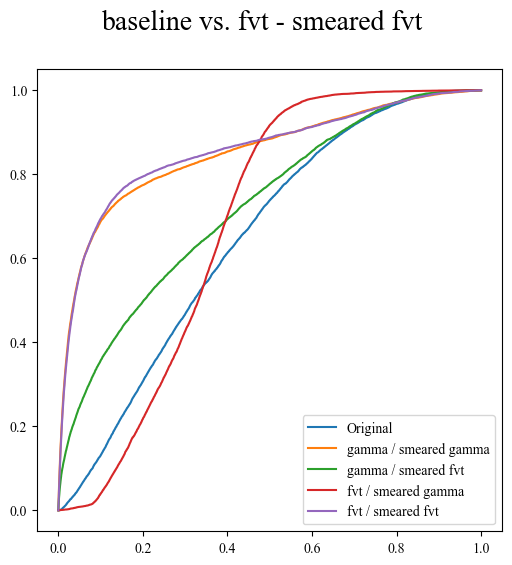

In [24]:
SR_stats = gamma_base / gamma_smeared
SR_stats_2 = gamma_base / probs_4b_smeared
SR_stats_3 = probs_4b_base / gamma_smeared
SR_stats_4 = probs_4b_base / probs_4b_smeared

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
fig.suptitle("baseline vs. fvt - smeared fvt")
plot_sr_stats(events_tst, gamma_base, ax, label="Original")
plot_sr_stats(events_tst, SR_stats, ax, label="gamma / smeared gamma")
plot_sr_stats(events_tst, SR_stats_2, ax, label="gamma / smeared fvt")
plot_sr_stats(events_tst, SR_stats_3, ax, label="fvt / smeared gamma")
plot_sr_stats(events_tst, SR_stats_4, ax, label="fvt / smeared fvt")

plt.legend()
plt.show()

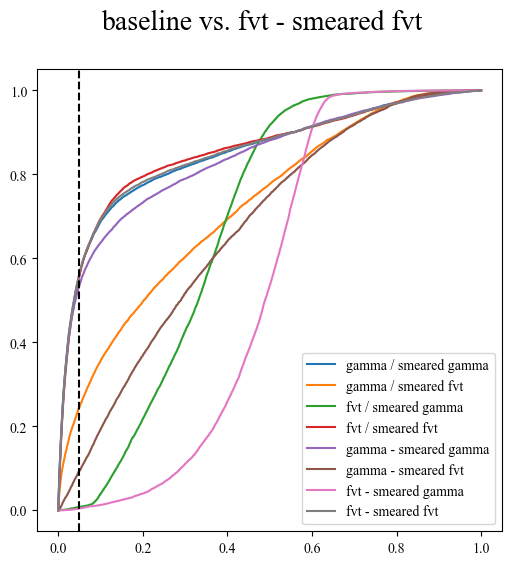

In [27]:
SR_stats_1 = gamma_base / gamma_smeared
SR_stats_2 = gamma_base / probs_4b_smeared
SR_stats_3 = probs_4b_base / gamma_smeared
SR_stats_4 = probs_4b_base / probs_4b_smeared

SR_stats_5 = gamma_base - gamma_smeared
SR_stats_6 = gamma_base - probs_4b_smeared
SR_stats_7 = probs_4b_base - gamma_smeared
SR_stats_8 = probs_4b_base - probs_4b_smeared

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
fig.suptitle("baseline vs. fvt - smeared fvt")
plot_sr_stats(events_tst, SR_stats_1, ax, label="gamma / smeared gamma")
plot_sr_stats(events_tst, SR_stats_2, ax, label="gamma / smeared fvt")
plot_sr_stats(events_tst, SR_stats_3, ax, label="fvt / smeared gamma")
plot_sr_stats(events_tst, SR_stats_4, ax, label="fvt / smeared fvt")
plot_sr_stats(events_tst, SR_stats_5, ax, label="gamma - smeared gamma")
plot_sr_stats(events_tst, SR_stats_6, ax, label="gamma - smeared fvt")
plot_sr_stats(events_tst, SR_stats_7, ax, label="fvt - smeared gamma")
plot_sr_stats(events_tst, SR_stats_8, ax, label="fvt - smeared fvt")
ax.axvline(0.05, color="black", linestyle="--")

plt.legend(loc="lower right")
plt.show()

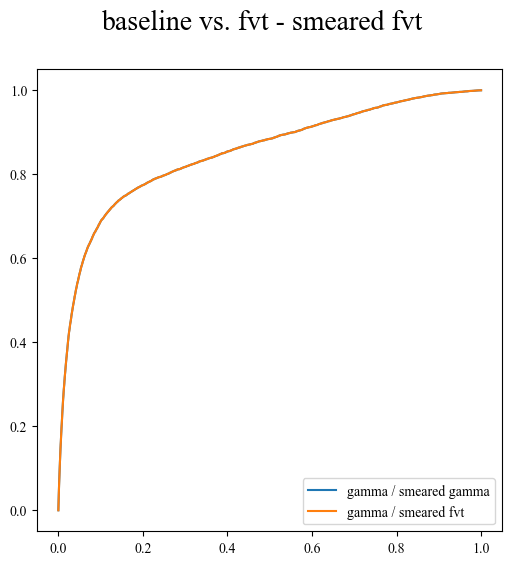

In [26]:
SR_stats_1 = gamma_base / gamma_smeared
SR_stats_2 = np.log(gamma_base) - np.log(gamma_smeared)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
fig.suptitle("baseline vs. fvt - smeared fvt")
plot_sr_stats(events_tst, SR_stats_1, ax, label="gamma / smeared gamma")
plot_sr_stats(events_tst, SR_stats_2, ax, label="gamma / smeared fvt")

plt.legend(loc="lower right")
plt.show()